# Experimenting with Voronoi binning as described by Cappellari2009

Info can be found here http://www-astro.physics.ox.ac.uk/~mxc/software/#binning


In [128]:
%matplotlib inline
from astropy.io import fits as pyfits
from astropy.table import Table,Column,join

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import os
plt.rcParams['text.usetex']=True
plt.rcParams['axes.linewidth'] = 3


In [2]:
x,y,bin_number = np.loadtxt('voronoi_2d_binning_output.txt',unpack=1)

In [3]:
# convert into a nice table 
c1 = Column(x,name='x')
c2 = Column(y, name='y') 
c3 = Column(bin_number, name='bin_number',dtype=int) 

data = Table()
data.add_columns([c1,c2,c3])

In [4]:
bins = set(data['bin_number'])

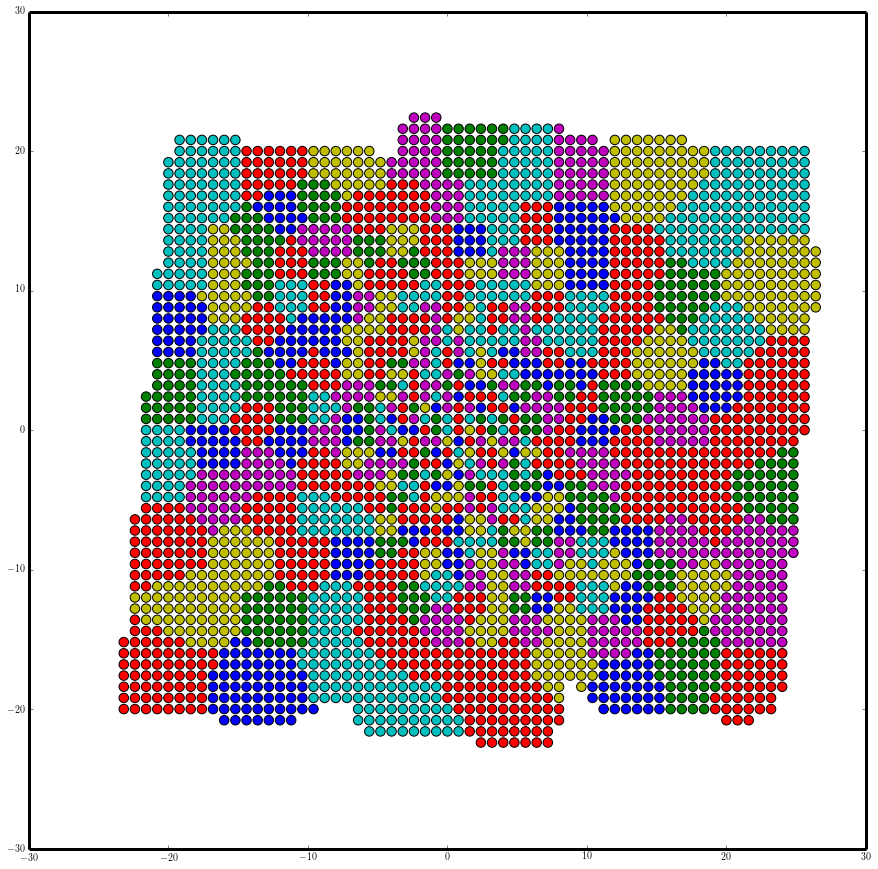

In [6]:
f=plt.figure(figsize=(15,15))
ax=f.add_subplot(111)
for i,n in enumerate(bins):
    if i % 1 == 0:
        color = 'r'
    if i % 2 == 0: 
        color = 'b'
    if i % 3 == 0:
        color = 'y'
    if i % 4 == 0:
        color = 'g'
    if i % 5 == 0:
        color = 'm'
    if i % 6 == 0:
        color = 'c'
    this_bin = (data['bin_number']==n)
    bin_x = np.median(data[this_bin]['x'])
    bin_y = np.median(data[this_bin]['y'])
    plt.scatter(data[this_bin]['x'],data[this_bin]['y'],c=color,edgecolor=None,s=90)
    #ax.annotate('%i'%n,xy=(bin_x,bin_y),xycoords='data',fontsize=30)

#OK now try some tests with ukidss data, using Ross's code as reference! https://github.com/RossHart/Debiasing/blob/master/binning.py

In [91]:
data=Table.read('../../data/ukidss_binning_data.fits')

In [9]:
R50 = 'PETROR50_R_KPC'
Mr = 'PETROMAG_MR'
n_rect_bins=100
rect_bin_val, R50_bin_edges, Mr_bin_edges = np.histogram2d(data[R50], data[Mr],n_rect_bins)
extent = [R50_bin_edges[0],R50_bin_edges[-1],Mr_bin_edges[0],Mr_bin_edges[-1]]

(-14, -24)

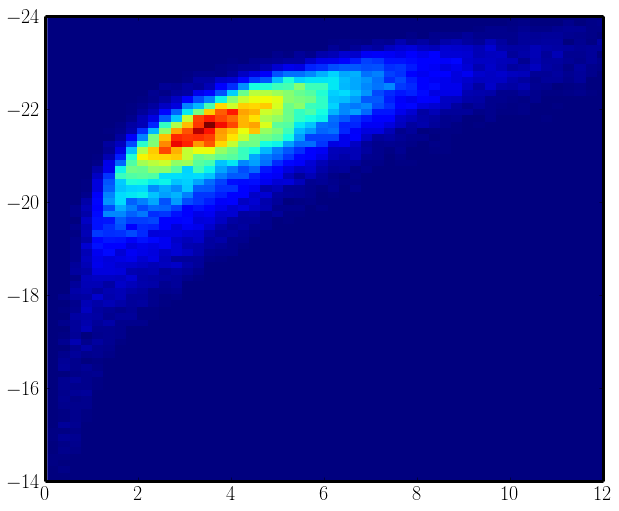

In [41]:
#plot rectangular bins

f=plt.figure(figsize=(10,10))

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20 

plt.imshow(rect_bin_val.T,interpolation='nearest',extent=extent,origin='lower')
plt.gca().invert_yaxis()
plt.xlim(0,12)
plt.ylim(-14,-24)

In [5]:
# bin centers and number of bins in R50 and M
R50_bin_centres = 0.5*(R50_bin_edges[:-1] + R50_bin_edges[1:])
Mr_bin_centres = 0.5*(Mr_bin_edges[:-1] + Mr_bin_edges[1:]) 
n_R50_bins = len(R50_bin_centres)
n_Mr_bins = len(Mr_bin_centres)

#bin ranges
R50_bins_min, Mr_bins_min = map(np.min, (R50_bin_centres, Mr_bin_centres))
R50_bins_max, Mr_bins_max = map(np.max, (R50_bin_centres, Mr_bin_centres))
R50_bins_range = R50_bins_max - R50_bins_min
Mr_bins_range = Mr_bins_max - Mr_bins_min


In [32]:
# 'Ravel' out the coordinate bins (length of this array = n_bin*n_bin)
#So basically an array of the bin centers, but repeated n_bin times for each of the n_bin bins. 
R50_bin_coords = R50_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).ravel()
Mr_bin_coords = Mr_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).T.ravel()


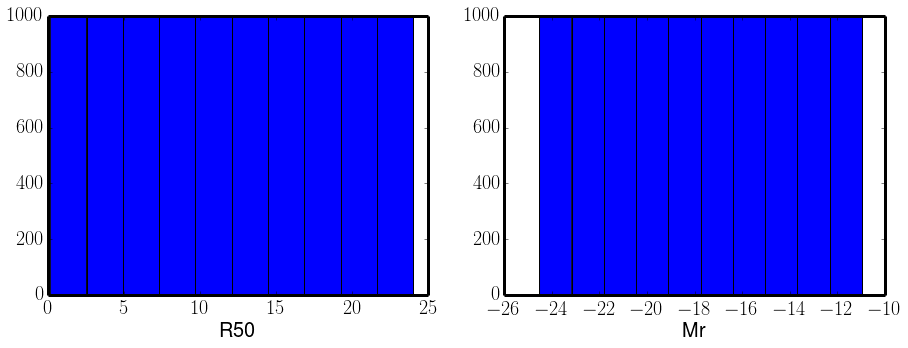

In [42]:
#Just to help me visualize these ravelled arrays: Each bin center is repeated 1000 times. Because reasons. 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20 

f = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1,2)

plt.subplot(gs[0,0])
plt.hist(R50_bin_coords)
plt.xlabel('R50',fontsize=20)

plt.subplot(gs[0,1])
plt.hist(Mr_bin_coords)
plt.xlabel('Mr',fontsize=20)

In [51]:
# Only keep bins that contain a galaxy:
signal = rect_bin_val.ravel() # signal=number of gals.
ok_bin = (signal > 0).nonzero()[0]
signal = signal[ok_bin]


(0, 200)

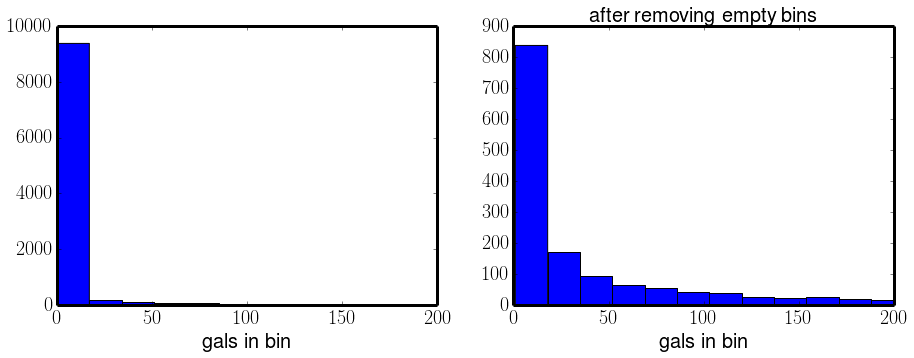

In [54]:
#Again to help me visualize the raveling: Number of galaxies per bin, before and after removing empty bins. 
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20 

f = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1,2)

plt.subplot(gs[0,0])
plt.hist(rect_bin_val.ravel(),20)
plt.xlabel('gals in bin',fontsize=20)
plt.xlim(0,200)
plt.subplot(gs[0,1])
plt.hist(signal,20)
plt.xlabel('gals in bin',fontsize=20)
plt.title('after removing empty bins',fontsize=20)
plt.xlim(0,200)


In [55]:
# Normalise x + y to be between 0 and 1:
x = (R50_bin_coords[ok_bin] - R50_bins_min) / R50_bins_range
y = (Mr_bin_coords[ok_bin] - Mr_bins_min) / Mr_bins_range


In [62]:
n_per_voronoi_bin=500
noise = np.sqrt(signal)
targetSN = np.sqrt(n_per_voronoi_bin)


In [79]:
len(y)

1464

In [66]:
output = voronoi_2d_binning(x, y, signal, noise, targetSN, plot=0, quiet=1, wvt=True)
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = output


Bin-accretion...
154  initial bins.
Reassign bad bins...
115  good bins.
Modified Lloyd algorithm...
23  iterations.
Unbinned pixels:  0  /  1464
Fractional S/N scatter (%): 11.6564019335


In [80]:
c1 = Column(x,name='x')
c2 = Column(y, name='y') 
c3 = Column(binNum, name='bin_number',dtype=int) 

data = Table()
data.add_columns([c1,c2,c3])

In [82]:
bins = set(data['bin_number'])

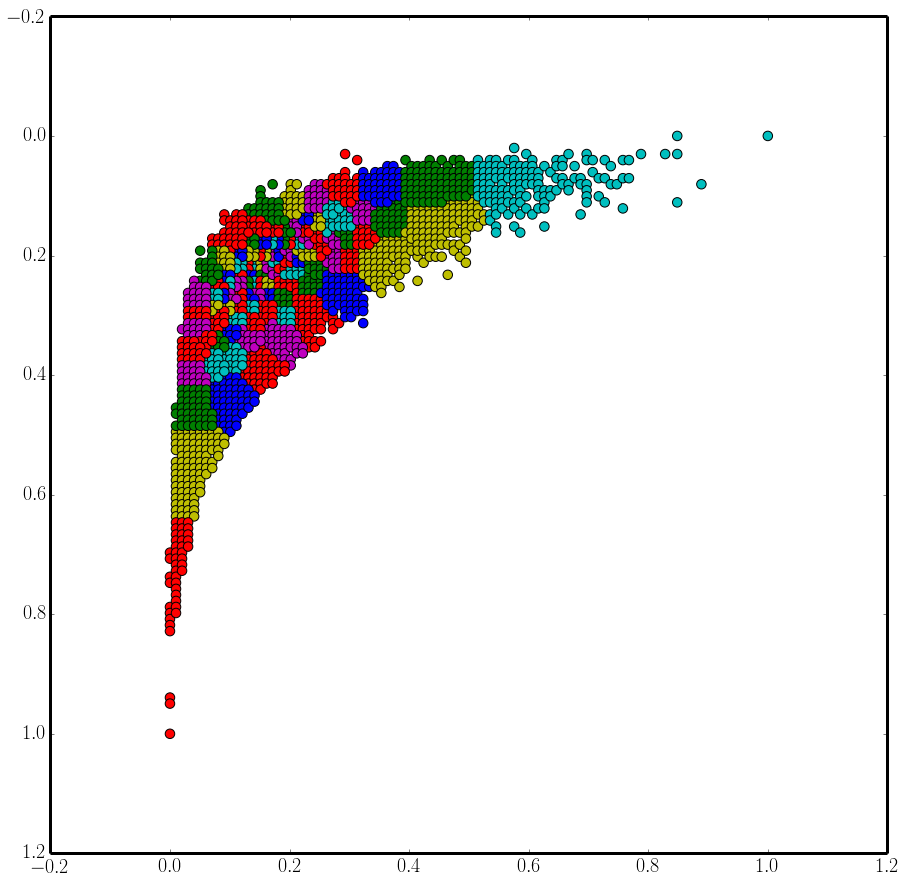

In [86]:
f=plt.figure(figsize=(15,15))
ax=f.add_subplot(111)
for i,n in enumerate(bins):
    if i % 1 == 0:
        color = 'r'
    if i % 2 == 0: 
        color = 'b'
    if i % 3 == 0:
        color = 'y'
    if i % 4 == 0:
        color = 'g'
    if i % 5 == 0:
        color = 'm'
    if i % 6 == 0:
        color = 'c'
    this_bin = (data['bin_number']==n)
    bin_x = np.median(data[this_bin]['x'])
    bin_y = np.median(data[this_bin]['y'])
    plt.scatter(data[this_bin]['x'],data[this_bin]['y'],c=color,edgecolor=None,s=90)
plt.gca().invert_yaxis()
    #ax.annotate('%i'%n,xy=(bin_x,bin_y),xycoords='data',fontsize=30)

In [139]:
def voronoi_binning(R50, Mr,n_rect_bins=100, n_per_voronoi_bin=5000,save=False):
    ''' Voronoi bin in terms of R50 and Mr'''
    
    rect_bin_val, R50_bin_edges, Mr_bin_edges = np.histogram2d(R50, Mr, n_rect_bins)

    rect_bins_table = Table(data=[R50_bin_edges, Mr_bin_edges],
                            names=['R50_bin_edges', 'Mr_bin_edges'])
    rect_bins_table.meta['nrectbin'] = n_rect_bins # add value for number of 
    # bins to the table. 
    
    # Get bin centres + number of bins:
    R50_bin_centres = 0.5*(R50_bin_edges[:-1] + R50_bin_edges[1:])
    Mr_bin_centres = 0.5*(Mr_bin_edges[:-1] + Mr_bin_edges[1:]) 
    n_R50_bins = len(R50_bin_centres)
    n_Mr_bins = len(Mr_bin_centres)

    # Get ranges:
    R50_bins_min, Mr_bins_min = map(np.min, (R50_bin_centres, Mr_bin_centres))
    R50_bins_max, Mr_bins_max = map(np.max, (R50_bin_centres, Mr_bin_centres))
    R50_bins_range = R50_bins_max - R50_bins_min
    Mr_bins_range = Mr_bins_max - Mr_bins_min
    
    # 'Ravel' out the coordinate bins (length of this array = n_bin*n_bin)
    R50_bin_coords = R50_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).ravel()
    Mr_bin_coords = Mr_bin_centres.repeat(n_rect_bins).reshape(n_rect_bins, n_rect_bins).T.ravel()

    # Only keep bins that contain a galaxy:
    signal = rect_bin_val.ravel() # signal=number of gals.
    ok_bin = (signal > 0).nonzero()[0]
    signal = signal[ok_bin]

    # Normalise x + y to be between 0 and 1:
    x = (R50_bin_coords[ok_bin] - R50_bins_min) / R50_bins_range
    y = (Mr_bin_coords[ok_bin] - Mr_bins_min) / Mr_bins_range

    # Voronoi_2d_binning aims for a target S/N
    noise = np.sqrt(signal)
    targetSN = np.sqrt(n_per_voronoi_bin)

    output = voronoi_2d_binning(x, y, signal, noise, targetSN, plot=0, quiet=1, wvt=True)
    binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = output
    
    return x,y,binNum

In [129]:
def plot_output(x,y,binNum):
    c1 = Column(x,name='x')
    c2 = Column(y, name='y') 
    c3 = Column(binNum, name='bin_number',dtype=int) 

    data = Table()
    data.add_columns([c1,c2,c3])
    bins = set(data['bin_number'])
    f=plt.figure(figsize=(15,15))
    ax=f.add_subplot(111)
    for i,n in enumerate(bins):
        this_bin = (data['bin_number']==n)
        bin_x = np.median(data[this_bin]['x'])
        bin_y = np.median(data[this_bin]['y'])
        color = "#%06x" % random.randint(0, 0xFFFFFF) #random color for this bin

        plt.scatter(data[this_bin]['x'],data[this_bin]['y'],c=color,edgecolor=None,s=90)
    plt.gca().invert_yaxis()
    #ax.annotate('%i'%n,xy=(bin_x,bin_y),xycoords='data',fontsize=30)

In [140]:
x,y,binNum = voronoi_binning(data[R50],data[Mr])

Bin-accretion...
20  initial bins.
Reassign bad bins...
11  good bins.
Modified Lloyd algorithm...
9  iterations.
Unbinned pixels:  0  /  1464
Fractional S/N scatter (%): 21.372276081


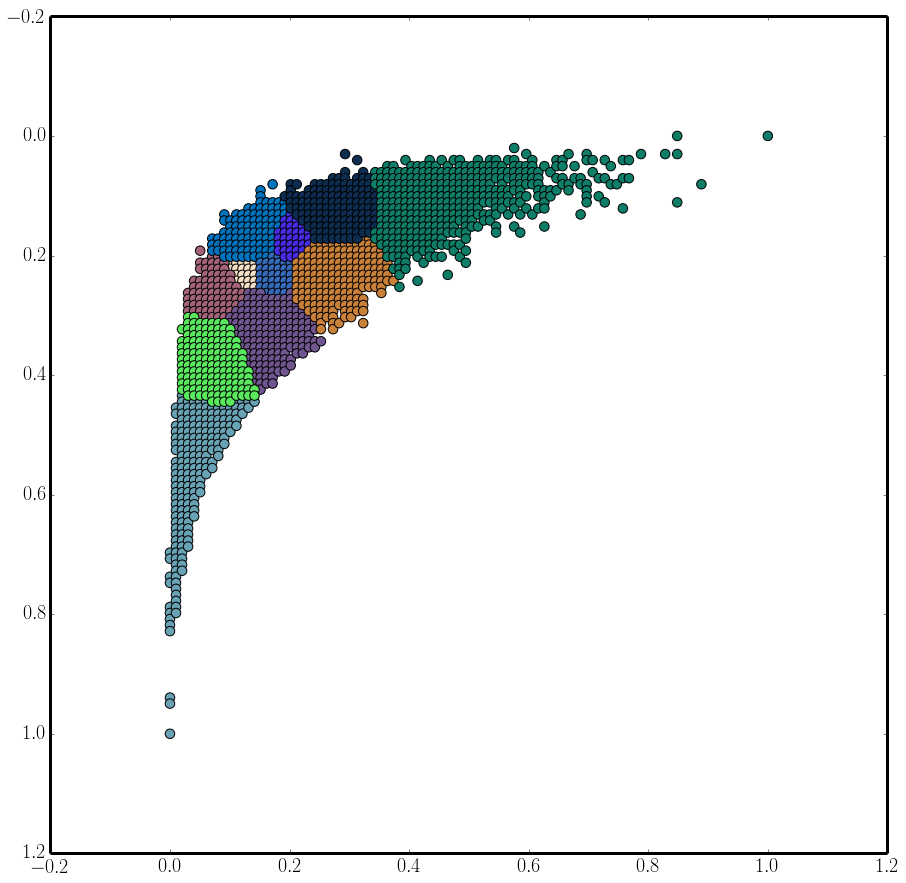

In [141]:
plot_output(x,y,binNum)

In [166]:
def value_of_pizza(deg,radius,price):
    area = (radius**2 * deg*np.pi/180.)/2
    value = price/area
    return round(value,2)

In [170]:
print 'Pizza on the left costs $%s per square inch.\n
Pizza on the right costs $%s per square inch.\n
Pizza on the left is a better deal.'% (value_of_pizza(60,6,1.5),value_of_pizza(45,7,1.7))

Pizza on the left costs $0.08 per square inch.
Pizza on the right costs $0.09 per square inch.
Pizza on the left is a better deal.


In [171]:
value_of_pizza(60,6,1.5)

0.08